In [59]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import re
import google.generativeai as genai
from config import GOOGLE_API_KEY
from config import ISBNDB_API_KEY
import time
import requests
from tqdm import tqdm

In [91]:
items = pd.read_csv('data/items.csv')

# Cleaning the original dataset

In [92]:
items['ISBN'] = items['ISBN Valid'].str.split(';').str[0]
items['title_clean'] = items['Title'].apply(lambda x: x.rstrip(' /') if isinstance(x, str) else np.nan)
items['google_api_title'] = items['title_clean'].str.split(' :').str[0]
(items['google_api_title'].isna().sum())
# No missing data for titles, therefore the title embedding is unaffected by data enhancing methods
def get_clean_author(author_series):
    def clean_author_string(author):
        if pd.isna(author):
            return None
        # Remove all digits and dashes
        cleaned = re.sub(r'[\d\-]', '', author)
        # Collapse multiple spaces and strip
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()
        return cleaned if cleaned else None

    clean_author = author_series.apply(clean_author_string)
    return clean_author

items['author_clean'] = get_clean_author(items['Author'])

In [4]:
token_count = items['google_api_title'].apply(lambda x: len(str(x).split()))
average_token_count = token_count.mean()
print('Average batch size:',2048/average_token_count)

Average batch size: 511.5065906603728


In [ ]:
# Configure your API key
genai.configure(api_key=GOOGLE_API_KEY)

# The name of the embedding model
embedding_model_name = 'models/embedding-001'

embeddings = []
batch_size = 400
# Loop through the items in batches
for i in range(0, len(items), batch_size):
    batch = items.iloc[i:i+batch_size]
    texts_to_embed = batch['google_api_title'].tolist()
    responses = genai.embed_content(model=embedding_model_name, content=texts_to_embed)
    embedding_batch = responses['embedding']
    embeddings += embedding_batch


In [ ]:
items['embedded_title'] = embeddings
items.iloc[:7500].to_csv('embeddings_part1.csv', index = False)
items.iloc[7500:].to_csv('embeddings_part2.csv', index = False)

In [ ]:

def get_isbn_by_title(book_title):
    base_url = "https://www.googleapis.com/books/v1/volumes"
    params = {
        "q": f'intitle:"{book_title}"',
        "maxResults": 10  # Check up to 10 results
    }
    response = requests.get(base_url, params=params)
    data = response.json()

    if "items" not in data:
        print("No books found.")
        return None

    for item in data["items"]:
        volume_info = item.get("volumeInfo", {})
        identifiers = volume_info.get("industryIdentifiers", [])
        for identifier in identifiers:
            if identifier["type"] == "ISBN_13":
                return identifier["identifier"]

    print("No ISBN-13 found in any of the results.")
    return None

# Example usage
isbn = get_isbn_by_title("Thinking, Fast and Slow")
print("ISBN-13:", isbn)

ISBN-13: 9781429969352


In [ ]:
# This is for all the books without an ISBN
# Can also directly use this to find the other info we're interested in
import requests

def get_isbn_by_title(book_title):
    base_url = "https://www.googleapis.com/books/v1/volumes"
    params = {
        "q": f'intitle:"{book_title}"',
        "maxResults": 3  # Limit search to top 10 results
    }
    response = requests.get(base_url, params=params)
    data = response.json()

    if "items" not in data:
        print("No books found.")
        return None

    for item in data["items"]:
        volume_info = item.get("volumeInfo", {})
        identifiers = volume_info.get("industryIdentifiers", [])
        for identifier in identifiers:
            if identifier.get("type") in ("ISBN_13", "ISBN_10"):
                return identifier.get("identifier")  # Return first available ISBN

    print("No ISBN found in any of the results.")
    return None

# Example usage
isbn = get_isbn_by_title("Thinking, Fast and Slow")
print("ISBN:", isbn)



ISBN: 9781429969352


In [23]:
def get_book_info_by_title(book_title):
    """Extracts missing data for books without an ISBN on the google books APi using the book's title. If no ISBN is found, the rest of the metadata of the first match is returned
    - book_title: str
    """
    base_url = "https://www.googleapis.com/books/v1/volumes"
    params = {
        "q": f'intitle:"{book_title}"',
        "maxResults": 10
    }
    response = requests.get(base_url, params=params)
    data = response.json()

    if "items" not in data:
        print("No books found.")
        return None

    first_valid_data = None  # fallback if no ISBN is found

    for item in data["items"]:
        volume_info = item.get("volumeInfo", {})

        # Extract fields early
        authors = volume_info.get("authors", [])
        language = volume_info.get("language", "")
        canonical_link = volume_info.get("canonicalVolumeLink", "")
        published_date = volume_info.get("publishedDate", "")
        image_link = volume_info.get("imageLinks", {}).get("thumbnail", "")
        description = volume_info.get("description", "")
        identifiers = volume_info.get("industryIdentifiers", [])
        subjects = volume_info.get('categories', [])

        entry_data = {
            "ISBN": None,
            "Author": ", ".join(authors),
            "Language": language,
            "CanonicalLink": canonical_link,
            "PublishedDate": published_date,
            "ImageLink": image_link,
            "Description": description,
            "Subjects": subjects
        }

        # Save the first result's metadata as fallback
        if first_valid_data is None:
            first_valid_data = entry_data

        # Check for ISBN (either type)
        for identifier in identifiers:
            if identifier.get("type") in ("ISBN_13", "ISBN_10"):
                entry_data["ISBN"] = identifier.get("identifier")
                return entry_data  # Found ISBN, return immediately

    # No ISBN found, return first available result info
    print("No ISBN found; returning fallback metadata.")
    return first_valid_data

# Data enhancing
## Google API
### Books with no ISBN

In [ ]:
nan_books = items[items['ISBN Valid'].isna()]

In [28]:
enhanced_missing_isbn = nan_books['google_api_title'].apply(get_book_info_by_title)

No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No books found.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; returning fallback metadata.
No ISBN found; r

In [ ]:
# Step 1: Handle NaNs
safe_results = [x if isinstance(x, dict) else {} for x in enhanced_missing_isbn]
# Step 2: Convert to DataFrame
info_df = pd.DataFrame(safe_results, index=nan_books.index)
# Handle subjects list -> sentence
info_df["Subjects"] = info_df["Subjects"].apply(
    lambda x: ", ".join(x) if isinstance(x, list) else ""
)

,ISBN,Author,Language,CanonicalLink,PublishedDate,ImageLink,Description,Subjects
261,None,Lucius Annaeus Seneca,fr,https://play.google.com/store/books/details?id...,1932,http://books.google.com/books/content?id=m5qZA...,,Philosophy
264,None,Lucius Annaeus Seneca,fr,https://play.google.com/store/books/details?id...,1932,http://books.google.com/books/content?id=m5qZA...,,Philosophy
269,2070108295,Charles Baudelaire,fr,https://books.google.com/books/about/Oeuvres_P...,1990,,,
367,2952930295,Jean-François Chevrier,fr,https://books.google.com/books/about/L_halluci...,2012,,L'Hallucination artistique (la formule est de ...,Art and literature
393,None,Karl Wieland,fr,https://books.google.com/books/about/Les_droit...,1914,http://books.google.com/books/content?id=yo7dw...,,Mortgages
...,...,...,...,...,...,...,...,...
15195,9785392066186,Suisse,fr,https://books.google.com/books/about/Code_p%C3...,2015-11-25,http://books.google.com/books/content?id=2fQEC...,Code pénal suisse du 21 décembre 1937; Etat le...,Law
15203,9781453697481,"Scriblerus, Talia Felix, John Davidson, Lawren...",en,https://books.google.com/books/about/La_Commed...,2010-08-02,http://books.google.com/books/content?id=_em-q...,The Commedia dell'Arte is best known through t...,Drama
15232,None,,fr,https://books.google.com/books/about/Payerne_v...,2015,,,
15245,None,Anton Pavlovich Chekhov,ru,https://books.google.com/books/about/Polnoe_so...,1971,,,


In [31]:
# Step 3: Combine with original DataFrame
# handle the subjects format first: from list to comma separated sentence
nan_books_enhanced = nan_books.combine_first(info_df)
nan_books_enhanced

,Author,CanonicalLink,Description,ISBN,ISBN Valid,ImageLink,Language,PublishedDate,Publisher,Subjects,Title,author_clean,google_api_title,i,title_clean
261,"Seneca, Lucius Annaeus, l'Ancien",https://play.google.com/store/books/details?id...,,None,NaN,http://books.google.com/books/content?id=m5qZA...,fr,1932,Garnier frères,Philosophy,Controverses ; et Suasoires /,"Seneca, Lucius Annaeus, l'Ancien",Controverses ; et Suasoires,261,Controverses ; et Suasoires
264,"Seneca, Lucius Annaeus, l'Ancien",https://play.google.com/store/books/details?id...,,None,NaN,http://books.google.com/books/content?id=m5qZA...,fr,1932,Garnier,Philosophy,Controverses ; et Suasoires /,"Seneca, Lucius Annaeus, l'Ancien",Controverses ; et Suasoires,264,Controverses ; et Suasoires
269,"Baudelaire, Charles",https://books.google.com/books/about/Oeuvres_P...,,2070108295,NaN,,fr,1990,puis Gallimard; La Pléiade,,"Oeuvres / Poésies de jeunesse, poésies diverse...","Baudelaire, Charles","Oeuvres / Poésies de jeunesse, poésies diverse...",269,"Oeuvres / Poésies de jeunesse, poésies diverse..."
367,"Quercy, Pierre",https://books.google.com/books/about/L_halluci...,L'Hallucination artistique (la formule est de ...,2952930295,NaN,,fr,2012,F Alcan,Art and literature,L'hallucination /,"Quercy, Pierre",L'hallucination,367,L'hallucination
393,"Wieland, Karl, 1864-1936",https://books.google.com/books/about/Les_droit...,,None,NaN,http://books.google.com/books/content?id=yo7dw...,fr,1914,M Giard et E Brière,droits réels--* droit civil--Suisse; Sachenrec...,Les droits réels dans le Code civil suisse /,"Wieland, Karl,",Les droits réels dans le Code civil suisse,393,Les droits réels dans le Code civil suisse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,Suisse,https://books.google.com/books/about/Code_p%C3...,Code pénal suisse du 21 décembre 1937; Etat le...,9785392066186,NaN,http://books.google.com/books/content?id=2fQEC...,fr,2015-11-25,diff OFCL; Chancellerie fédérale,Strafrecht; Strafgesetzbuch; Droit pénal; Schw...,Code pénal suisse : [du 21 décembre 1937 (état...,None,Code pénal suisse,15195,Code pénal suisse : [du 21 décembre 1937 (état...
15203,"Scriblerus, Talia Felix, John Davidson, Lawren...",https://books.google.com/books/about/La_Commed...,The Commedia dell'Arte is best known through t...,9781453697481,NaN,http://books.google.com/books/content?id=_em-q...,en,2010-08-02,Sansoni Antiquariato,commedia dell'arte--[anthologie],La Commedia dell'Arte : storia e testo /,None,La Commedia dell'Arte,15203,La Commedia dell'Arte : storia e testo
15232,,https://books.google.com/books/about/Payerne_v...,,None,NaN,,fr,2015,Editions du Caïon rodze,,"Payerne vracs : [ville, rues, archives, campag...",None,Payerne vracs,15232,"Payerne vracs : [ville, rues, archives, campag..."
15245,"Chekhov, Anton Pavlovich",https://books.google.com/books/about/Polnoe_so...,,None,NaN,,ru,1971,Nauka,,Polnoe sobranie sochineniĭ i pisem : v tridt︠s...,"Chekhov, Anton Pavlovich",Polnoe sobranie sochineniĭ i pisem,15245,Polnoe sobranie sochineniĭ i pisem : v tridt︠s...


In [ ]:
nan_books_enhanced.to_csv('google_api_enhanced/nan_books_enhanced.csv', index = False)

### Books with ISBNs

In [67]:
def search_google_books(isbn):
    params = {
        'q': f'isbn:{isbn}',
        'maxResults': 1,
        'printType': 'books',
        'projection': 'full'
        #'key': 'YOUR_API_KEY'  # optional
    }
    response = requests.get('https://www.googleapis.com/books/v1/volumes', params=params)
    book = response.json()
    
    if 'items' not in book:
        return {}
    else: 
        volume_info = book['items'][0]['volumeInfo']
        # Extract relevant fields 
        authors = volume_info.get("authors", [])
        language = volume_info.get("language", "")
        canonical_link = volume_info.get("canonicalVolumeLink", "")
        published_date = volume_info.get("publishedDate", "")
        image_link = volume_info.get("imageLinks", {}).get("thumbnail", "")
        description = volume_info.get("description", "")
        subjects = volume_info.get('categories', [])

    entry_data = {
        "Author": ", ".join(authors),
        "Language": language,
        "CanonicalLink": canonical_link,
        "PublishedDate": published_date,
        "ImageLink": image_link,
        "Description": description,
        "Subjects": subjects
    }
        
    return entry_data

In [8]:
not_nan_books = items[items['ISBN Valid'].notna()].copy()
not_nan_books

,Title,Author,ISBN Valid,Publisher,Subjects,i,ISBN,title_clean,google_api_title,author_clean
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0,9782871303336,Classification décimale universelle : édition ...,Classification décimale universelle,None
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1,9782278058327,Les interactions dans l'enseignement des langu...,Les interactions dans l'enseignement des langues,"Cicurel, Francine,"
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2,2343190194,Histoire de vie et recherche biographique : pe...,Histoire de vie et recherche biographique,None
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3,9782365350020,Ce livre devrait me permettre de résoudre le c...,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain,"
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4,9782702180815,Les années glorieuses : roman,Les années glorieuses,"Lemaitre, Pierre,"
...,...,...,...,...,...,...,...,...,...,...
15285,Nouvelles orientales /,"Yourcenar, Marguerite",2070299732; 9782070299737,Gallimard,NaN,15285,2070299732,Nouvelles orientales,Nouvelles orientales,"Yourcenar, Marguerite"
15286,Le vagabond de Tokyo /,"Fukutani, Takashi, 1952-2000",9782353480111; 235348011X; 9782353480241; 2353...,Le Lézard noir,Mangas,15286,9782353480111,Le vagabond de Tokyo,Le vagabond de Tokyo,"Fukutani, Takashi,"
15287,God of high school : le match contre les dieux /,"Park, Yong-Je",9782382880203; 2382880201; 9782382880210; 2382...,Kbooks,NaN,15287,9782382880203,God of high school : le match contre les dieux,God of high school,"Park, YongJe"
15288,Blue Lock /,"Kaneshiro, Muneyuki",9782811650254; 2811650253; 9782811661274; 2811...,Pika,Compétitions; Football; Entraînement (sports);...,15288,9782811650254,Blue Lock,Blue Lock,"Kaneshiro, Muneyuki"


In [ ]:
enhanced_isbn = []
batch_size = 10
# Loop through the items in batches
for i in range(0, 15500, batch_size):
    batch = not_nan_books.iloc[i:i+batch_size]
    enhanced_isbn_batch = batch['ISBN'].apply(search_google_books)
    enhanced_isbn.extend(enhanced_isbn_batch)

In [ ]:
info_df = pd.DataFrame(enhanced_isbn, index=nan_books.index)
# Handle subjects list -> sentence
info_df["Subjects"] = info_df["Subjects"].apply(
    lambda x: ", ".join(x) if isinstance(x, list) else ""
    )
# Step 3: Combine with original DataFrame
# handle the subjects format first: from list to comma separated sentence
not_nan_books_enhanced = not_nan_books.combine_first(info_df)

In [ ]:
not_nan_books_enhanced.to_csv('google_api_enhanced/not_nan_books_enhanced.csv', index = False)

In [ ]:
not_nan_books_enhanced = pd.read_csv('google_api_enhanced/not_nan_books_enhanced.csv')

In [53]:
# Need to merge to handle the way it was stored
merged = not_nan_books.reset_index(drop=True).combine_first(
         not_nan_books_enhanced.reset_index(drop=True))
merged['author_clean'] = get_clean_author(merged['Author'])
merged['PublishedDate'] = merged['PublishedDate'][:4]

In [ ]:
all_books_enhanced = pd.concat([nan_books_enhanced, merged], ignore_index=True)
all_books_enhanced.drop(columns = ['Author','ISBN Valid'],inplace = True)

In [ ]:
all_books_enhanced.to_csv('google_api_enhanced/all_items_enhanced.csv', index = False)

In [46]:
print(all_books_enhanced['ImageLink'].notna().sum())

3857


In [ ]:
all_books_enhanced = pd.read_csv('google_api_enhanced/all_items_enhanced.csv')
print(all_books_enhanced['Description'].notna().sum())
all_books_enhanced['PublishedDate'] = all_books_enhanced['PublishedDate'].astype(str).str[:4]
all_books_enhanced.fillna('', inplace = True)
# Creating all the combinations relevant for embedding
all_books_enhanced['title_description'] = all_books_enhanced['title_clean'] + ' ' + all_books_enhanced['Description']
all_books_enhanced['author_title_description'] = all_books_enhanced['author_clean'] + ' ' + all_books_enhanced['title_clean'] + ' ' + all_books_enhanced['Description']
all_books_enhanced['author_date_title_description'] = all_books_enhanced['author_clean'] + ' ' + all_books_enhanced['PublishedDate'] + ' ' + all_books_enhanced['title_clean'] + ' ' + all_books_enhanced['Description']
all_books_enhanced['author_date_title'] = all_books_enhanced['author_clean'] + ' ' + all_books_enhanced['PublishedDate'] + ' ' + all_books_enhanced['title_clean'] 
all_books_enhanced['author_date_title_subjects'] = all_books_enhanced['author_clean'] + ' ' + all_books_enhanced['PublishedDate'] + ' ' + all_books_enhanced['title_clean'] + ' ' + all_books_enhanced['Subjects']
all_books_enhanced['author_title_subjects'] = all_books_enhanced['author_clean'] + ' ' + ' ' + all_books_enhanced['title_clean'] + ' ' + all_books_enhanced['Subjects']

7067


In [57]:
# Prioritising top combinations 
top_columns = ['title_description','author_date_title_description','author_date_title_subjects']

In [60]:
# Configure your API key
genai.configure(api_key=GOOGLE_API_KEY)

# The name of the embedding model
def generate_embeddings(items, column = 'google_api_enhanced', batch_size=400):
    """
    Generate embeddings for a given DataFrame of items using the specified embedding model.

    Parameters:
    - items (pd.DataFrame): DataFrame containing the items to embed.
    - column (str): Name of the column to embed
    - batch_size (int): Number of items to process in each batch.

    Returns:
    - list: A list of embeddings.
    """
    embedding_model_name = 'models/embedding-001'
    embeddings = []
    for i in range(0, len(items), batch_size):
        batch = items.iloc[i:i+batch_size]
        texts_to_embed = batch[column].tolist()
        responses = genai.embed_content(model=embedding_model_name, content=texts_to_embed)
        embedding_batch = responses['embedding']
        embeddings += embedding_batch
    return embeddings

In [56]:
import os
def save_embeddings(dataframe, columns, extra_description = ''):
    split = round(len(dataframe) / 2)
    
    for column in tqdm(columns, desc="Embedding columns"):
        os.makedirs(f'final_items{extra_description}/{column}', exist_ok=True)
        
        for batch in tqdm([0, 1], desc=f"Batches for {column}", leave=False):
            items_batch = dataframe[batch * split : (batch + 1) * split].copy()
            embeddings = generate_embeddings(items_batch, column)
            items_batch['embedding'] = embeddings

            items_batch.to_csv(f'final_items{extra_description}/{column}/embeddings_part{batch+1}.csv', index=False)

In [ ]:
split = round(len(all_books_enhanced)/2)
for column in top_columns:
    for batch in [0,1]:
        items_batch = all_books_enhanced[batch*split:(batch+1)*split].copy()
        embeddings = generate_embeddings(items_batch,column)
        items_batch['embedding'] = embeddings
        items_batch.to_csv(f'{column}/embeddings_part{batch+1}.csv')

## Using the ISBN Database

In [10]:
nan_books_enhanced = pd.read_csv('google_api_enhanced/nan_books_enhanced.csv')

In [11]:
# Making use of the extra isbns that we got from the first data extraction
items.set_index('i', inplace=True)
print(items['ISBN'].isna().sum())
nan_books_enhanced.set_index('i',inplace=True)
items['ISBN'] = items['ISBN'].combine_first(nan_books_enhanced['ISBN'])
print(items['ISBN'].isna().sum())
items.reset_index(inplace=True)

723
356


In [12]:
# === CONFIGURATION ===
API_URL = 'https://api2.isbndb.com/books'
HEADERS = {
    'Authorization': ISBNDB_API_KEY,
    'accept': 'application/json',
    'Content-Type': 'application/json',
}
BATCH_SIZE = 100
API_SLEEP = 1  # seconds

# === LOAD DATAFRAME ===
df = items.copy()  # Ensure this is defined

# === EXTRACT FIRST VALID ISBN (10 or 13 digits) ===
def extract_isbn(text):
    if isinstance(text, str):
        for val in re.split(r'[;,]', text):
            cleaned = val.strip().replace('-', '')
            if cleaned.isdigit() and len(cleaned) in (10, 13):
                return cleaned
    return None

df['first_isbn'] = df['ISBN Valid'].apply(extract_isbn)

# === PREPARE UNIQUE ISBNs ===
unique_isbns = df['first_isbn'].dropna().drop_duplicates().tolist()
isbn_batches = [unique_isbns[i:i + BATCH_SIZE] for i in range(0, len(unique_isbns), BATCH_SIZE)]

# === FETCH BOOK DATA ===
book_data = []

for batch in tqdm(isbn_batches, desc="Fetching ISBNs", unit="batch"):
    try:
        payload_str = 'isbns=' + ','.join(batch)
        response = requests.post(API_URL, headers=HEADERS, data=payload_str)

        if response.status_code == 200:
            books = response.json().get('data', [])
            book_data.extend(books)
    except Exception:
        pass
    time.sleep(API_SLEEP)

# === SAVE RESULTS ===
books_df = pd.DataFrame(book_data)

books_df = books_df.apply(
    lambda x: x.replace("\u2028", "").replace("\u2029", "") if isinstance(x, str) else x
)

books_df.to_csv('isbn_enriched_data.csv', index=False)

Fetching ISBNs: 100%|██████████| 145/145 [04:34<00:00,  1.90s/batch]


In [13]:
books_df.drop(['msrp','binding', 'isbn', 'edition', 'related', 'dewey_decimal','publisher', 'title_long', 'dimensions', 'dimensions_structured', 'pages'], axis = 1,inplace=True)

In [14]:
books_df['isbn13']

0        9782130486855
1        9791092272406
2        9782228929097
3        9782353482788
4        9782878271980
             ...      
13732    9782296569089
13733    9781101907870
13734    9780323530378
13735    9782070299737
13736    9780273731917
Name: isbn13, Length: 13737, dtype: object

In [15]:
df_isbn13 = df[df['first_isbn'].str.len() == 13]
df_isbn13 = df_isbn13.merge(books_df, how='left', left_on='first_isbn', right_on='isbn13')

In [16]:
df_isbn10 = df[df['first_isbn'].str.len() == 10]
df_isbn10= df_isbn10.merge(books_df, how = 'left', left_on = 'first_isbn', right_on = 'isbn10')

In [17]:
for _, row in df_isbn10.sample(20).iterrows():
    print(row['image'], row['title'])

https://images.isbndb.com/covers/12663893483514.jpg Schweizerisches Haftpflichtrecht (German Edition)
https://images.isbndb.com/covers/13290053482473.jpg Narrative as Virtual Reality: Immersion and Interactivity in Literature and Electronic Media (Parallax: Re-visions of Culture and Society)
https://images.isbndb.com/covers/5601403482907.jpg Theorie De La Litterature: Testes Des Formelistes Russes
https://images.isbndb.com/covers/2518723483224.jpg La saga des émigrants - tome 1: Au pays
https://images.isbndb.com/covers/16334763482996.jpg Sauvegarde des collections du patrimoine
https://images.isbndb.com/covers/14640833483164.jpg Disparitions (Tableaux volés)
https://images.isbndb.com/covers/10656413482275.jpg Harrap's weis mattutat : dictionnaire allemand-français pons
https://images.isbndb.com/covers/18287963482946.jpg Naissance de l'écoféminisme
https://images.isbndb.com/covers/15305703482946.jpg Histoire de la France littéraire. Volume I: Naissances et Renaissances. Moyen Âge - XVIe

In [18]:
df_otherisbn = df[(df['first_isbn'].str.len() != 10) & (df['first_isbn'].str.len() != 13)]
df_otherisbn['first_isbn'].notna().sum()

np.int64(0)

In [19]:
df_all_isbn = pd.concat([df_isbn13, df_isbn10, df_otherisbn], ignore_index=True)
df_all_isbn.drop_duplicates(subset='i', inplace = True)
df_all_isbn

,i,Title,Author,ISBN Valid,Publisher,Subjects,ISBN,title_clean,google_api_title,author_clean,...,synopsis,language,image,image_original,date_published,subjects,authors,title,isbn13,isbn10
0,0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,9782871303336,Classification décimale universelle : édition ...,Classification décimale universelle,None,...,NaN,fr,https://images.isbndb.com/covers/8447463483210...,https://images.isbndb.com/covers/original/8447...,2012-03-05,NaN,[unknown author],Classification décimale universelle : Edition ...,9782871303336,2871303339
1,1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,9782278058327,Les interactions dans l'enseignement des langu...,Les interactions dans l'enseignement des langues,"Cicurel, Francine,",...,Agir professoral et pratiques de classe.<br/>U...,fr,https://images.isbndb.com/covers/2099063482999...,https://images.isbndb.com/covers/original/2099...,2011-11-09,"[Education & Teaching, Schools & Teaching]",[Francine Cicurel],Les interactions dans l'enseignement des langu...,9782278058327,2278058320
2,3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,9782365350020,Ce livre devrait me permettre de résoudre le c...,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain,",...,Product Description<br/><br/><br/>Sylvain Maza...,fr,https://images.isbndb.com/covers/4356503483030...,https://images.isbndb.com/covers/original/4356...,2012-06-07,[Subjects],[Sylvain Sylvain mazas],ce livre devrait me permettre de resoudre le c...,9782365350020,236535002X
3,4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,9782702180815,Les années glorieuses : roman,Les années glorieuses,"Lemaitre, Pierre,",...,"La famille PelletierTrois histoires d’amour, u...",fr,https://images.isbndb.com/covers/2369653483150...,https://images.isbndb.com/covers/original/2369...,2022-01-25,"[Literature & Fiction, Genre Fiction, Literary]",[Pierre Lemaitre],Le Grand Monde,9782702180815,2702180817
4,5,100 idées pour mieux gérer les troubles de l'a...,"Lussier, Francine",9782353450428; 2353450423,Tom Pousse,Trouble déficitaire de l'attention avec ou san...,9782353450428,100 idées pour mieux gérer les troubles de l'a...,100 idées pour mieux gérer les troubles de l'a...,"Lussier, Francine",...,"Chaque jour, le parent, l'enseignant, est conf...",fr,https://images.isbndb.com/covers/2578953348302...,https://images.isbndb.com/covers/original/2578...,2011-01-01,[Teen & Young Adult],[],100 idées pour mieux gérer les troubles de l'a...,9782353450428,2353450423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15335,15195,Code pénal suisse : [du 21 décembre 1937 (état...,NaN,NaN,diff OFCL; Chancellerie fédérale,Strafrecht; Strafgesetzbuch; Droit pénal; Schw...,9791036919473,Code pénal suisse : [du 21 décembre 1937 (état...,Code pénal suisse,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15336,15203,La Commedia dell'Arte : storia e testo /,NaN,NaN,Sansoni Antiquariato,commedia dell'arte--[anthologie],9781453697481,La Commedia dell'Arte : storia e testo,La Commedia dell'Arte,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15337,15232,"Payerne vracs : [ville, rues, archives, campag...",NaN,NaN,Editions du Caïon rodze,NaN,NaN,"Payerne vracs : [ville, rues, archives, campag...",Payerne vracs,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15338,15245,Polnoe sobranie sochineniĭ i pisem : v tridt︠s...,"Chekhov, Anton Pavlovich",NaN,Nauka,NaN,NaN,Polnoe sobranie sochineniĭ i pisem : v tridt︠s...,Polnoe sobranie sochineniĭ i pisem,"Chekhov, Anton P

In [20]:
# Remove <br/> and <br> tags from the 'synopsis' column in merged
df_all_isbn['synopsis'] = df_all_isbn['synopsis'].replace({r'<br\s*/?>': ' '}, regex=True)
# Convert from list of str to str
for column in ['authors','subjects']:
    df_all_isbn[column] = df_all_isbn[column].apply(
        lambda x: ", ".join(x) if isinstance(x, list) else ""
    )

# Clean paragraph separators from all string columns in the DataFrame
df_all_isbn = df_all_isbn.apply(
    lambda x: x.replace("\u2028", "").replace("\u2029", "") if isinstance(x, str) else x
)

# Save cleaned DataFrame to CSV
df_all_isbn.to_csv("isbndb_enhanced_items.csv", index=False)


### Combining the data from both data enhancing techniques

In [ ]:
df_all_items = pd.read_csv('google_api_enhanced/all_items_enhanced.csv').sort_values('i',ascending = True)
df_all_isbn = pd.read_csv('enhancing/isbndb_enhanced_items.csv')
# Rename columns in df_all_isbn to match df_all_items

column_map = {
    #'ImageLink': 'image',
    'Language': 'language',
    'PublishedDate': 'date_published',
    'Subjects': 'subjects',
    'author_clean': 'authors',
    'title_clean': 'title',
    'Description': 'synopsis'  # Assuming this is the corresponding column
}


In [23]:
for target_col, source_col in column_map.items():
    df_all_items[target_col] = df_all_items[target_col].combine_first(df_all_isbn[source_col])

In [30]:
def clean_text(text):
    if isinstance(text, str):
        return text.replace('\n', ' ').replace('\r', ' ')
    return text

# Apply to all object (text) columns
for col in df_all_items.select_dtypes(include='object').columns:
    df_all_items[col] = df_all_items[col].apply(clean_text)

df_all_items['Description'] = df_all_items['Description'].replace({r'<br\s*/?>': ' '}, regex=True)

# Now save
df_all_items = df_all_items.merge(df_all_isbn[['i','image']], on = 'i')
df_all_items.to_csv('items_enhanced_final.csv', index=False)

### Embeddings on the dataset

In [ ]:
df_all_items_before = pd.read_csv('google_api_enhanced/all_items_enhanced.csv').sort_values('i',ascending = True)
df_all_items_before.isna().sum()

Unnamed: 0              0
CanonicalLink        1304
Description          8224
ISBN                  351
ImageLink           11758
Language             1304
PublishedDate       14577
Publisher              25
Subjects              266
Title                   0
author_clean          993
google_api_title        0
i                       0
title_clean             0
dtype: int64

In [239]:
df_all_items.isna().sum()

Unnamed: 0              0
CanonicalLink        1304
Description          8224
ISBN                  351
ImageLink           11758
Language             1304
PublishedDate       14577
Publisher              25
Subjects              266
Title                   0
author_clean          993
google_api_title        0
i                       0
title_clean             0
dtype: int64

In [212]:
df_all_items.fillna("", inplace=True)
df_all_items['PublishedDate'] = df_all_items['PublishedDate'].astype(str).str[:4]

In [4]:
def create_embeddings_columns(df):
    df['title_description'] = df['title_clean'] + ' ' + df['Description']
    df['date_title_description'] = df['PublishedDate'] + ' '+ df['title_clean'] + ' ' + df['Description']
    df['author_title_description'] = df['author_clean'] + ' ' + df['title_clean'] + ' ' + df['Description']
    df['author_date_title_description'] = df['author_clean'] + ' ' + df['PublishedDate'] + ' ' + df['title_clean'] + ' ' + df['Description']
    df['author_date_title'] = df['author_clean'] + ' ' + df['PublishedDate'] + ' ' + df['title_clean'] 
    df['author_date_title_subjects'] = df['author_clean'] + ' ' + df['PublishedDate'] + ' ' + df['title_clean'] + ' ' + df['Subjects']
    df['author_title_subjects'] = df['author_clean'] + ' ' + ' ' + df['title_clean'] + ' ' + df['Subjects']

In [86]:
create_embeddings_columns(df_all_items)
all_columns = ['title_clean','title_description','date_title_description','author_title_description','author_date_title_description','author_date_title','author_date_title_subjects','author_title_subjects']
priority_columns = ['title_clean','title_description','date_title_description','author_date_title_description','author_date_title_subjects']

In [ ]:
save_embeddings(df_all_items,priority_columns)

Embedding columns: 100%|██████████| 5/5 [17:33<00:00, 210.68s/it]


In [ ]:
df_all_isbn = pd.read_csv(
    "enhancing/isbndb_enhanced_items.csv",
    engine="python")
df_all_isbn

,i,Title,Author,ISBN Valid,Publisher,Subjects,ISBN,title_clean,google_api_title,author_clean,...,synopsis,language,image,image_original,date_published,subjects,authors,title,isbn13,isbn10
0,0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,9782871303336,Classification décimale universelle : édition ...,Classification décimale universelle,NaN,...,NaN,fr,https://images.isbndb.com/covers/8447463483210...,https://images.isbndb.com/covers/original/8447...,2012-03-05,NaN,unknown author,Classification décimale universelle : Edition ...,9.782871e+12,2871303339
1,1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,9782278058327,Les interactions dans l'enseignement des langu...,Les interactions dans l'enseignement des langues,"Cicurel, Francine,",...,Agir professoral et pratiques de classe. Une r...,fr,https://images.isbndb.com/covers/2099063482999...,https://images.isbndb.com/covers/original/2099...,2011-11-09,"Education & Teaching, Schools & Teaching",Francine Cicurel,Les interactions dans l'enseignement des langu...,9.782278e+12,2278058320
2,3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,9782365350020,Ce livre devrait me permettre de résoudre le c...,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain,",...,"Product Description Sylvain Mazas, étudiants...",fr,https://images.isbndb.com/covers/4356503483030...,https://images.isbndb.com/covers/original/4356...,2012-06-07,Subjects,Sylvain Sylvain mazas,ce livre devrait me permettre de resoudre le c...,9.782365e+12,236535002X
3,4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,9782702180815,Les années glorieuses : roman,Les années glorieuses,"Lemaitre, Pierre,",...,"La famille PelletierTrois histoires d’amour, u...",fr,https://images.isbndb.com/covers/2369653483150...,https://images.isbndb.com/covers/original/2369...,2022-01-25,"Literature & Fiction, Genre Fiction, Literary",Pierre Lemaitre,Le Grand Monde,9.782702e+12,2702180817
4,5,100 idées pour mieux gérer les troubles de l'a...,"Lussier, Francine",9782353450428; 2353450423,Tom Pousse,Trouble déficitaire de l'attention avec ou san...,9782353450428,100 idées pour mieux gérer les troubles de l'a...,100 idées pour mieux gérer les troubles de l'a...,"Lussier, Francine",...,"Chaque jour, le parent, l'enseignant, est conf...",fr,https://images.isbndb.com/covers/2578953348302...,https://images.isbndb.com/covers/original/2578...,2011-01-01,Teen & Young Adult,NaN,100 idées pour mieux gérer les troubles de l'a...,9.782353e+12,2353450423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15286,15195,Code pénal suisse : [du 21 décembre 1937 (état...,NaN,NaN,diff OFCL; Chancellerie fédérale,Strafrecht; Strafgesetzbuch; Droit pénal; Schw...,9791036919473,Code pénal suisse : [du 21 décembre 1937 (état...,Code pénal suisse,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15287,15203,La Commedia dell'Arte : storia e testo /,NaN,NaN,Sansoni Antiquariato,commedia dell'arte--[anthologie],9781453697481,La Commedia dell'Arte : storia e testo,La Commedia dell'Arte,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15288,15232,"Payerne vracs : [ville, rues, archives, campag...",NaN,NaN,Editions du Caïon rodze,NaN,NaN,"Payerne vracs : [ville, rues, archives, campag...",Payerne vracs,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15289,15245,Polnoe sobranie sochineniĭ i pisem : v tridt︠s...,"Chekhov, Anton Pavlovich",NaN,Nauka,NaN,NaN,Polnoe sobranie sochineniĭ i pisem : v tridt︠s...,Polnoe sobranie sochineniĭ i pisem,"Chekhov, Anton Pavlovich",...,NaN,NaN,Na

In [ ]:
# Still struggling with line and paragraph separators
with open("isbndb_enhanced_items.csv", "r", encoding="utf-8") as infile:
    cleaned = infile.read().replace('\u2028', '\n').replace('\u2029', '\n')

with open("cleaned_isbndb.csv", "w", encoding="utf-8") as outfile:
    outfile.write(cleaned)

df_all_isbn = pd.read_csv("cleaned_isbndb.csv")
df_all_isbn
df_all_isbn['author_clean'] = df_all_isbn['author_clean'].apply(lambda x: re.sub(r'[\u200f\u202c]', '', str(x)))
df_all_isbn = df_all_isbn[df_all_isbn['i'].apply(lambda x: str(x).isdigit())]
df_all_isbn.to_csv("enhancing/isbndb_enhanced_items.csv", index=False)

In [95]:
# Giving priority to the ISBN DB for data enhancing instead of the google api
reverse_column_map = {
    #'ImageLink': 'image',
    'language': 'Language',
    'date_published': 'PublishedDate',
    'subjects': 'Subjects',
    'authors': 'author_clean',
    'title': 'title_clean',
    'synopsis': 'Description'  # Assuming this is the corresponding column
}
items['author_clean'] = items['author_clean'].combine_first(df_all_isbn['authors'])
items['title_clean'] = items['title_clean'].combine_first(df_all_isbn['title'])
# Ensure both 'i' columns are of the same type (string)
items['i'] = items['i'].astype(str)
df_all_isbn['i'] = df_all_isbn['i'].astype(str)

items = items.merge(df_all_isbn[['synopsis', 'language', 'image','i','date_published']], on='i', how='left')

In [96]:
items.rename(columns=reverse_column_map, inplace=True)

def clean_text(text):
    if isinstance(text, str):
        return text.replace('\n', ' ').replace('\r', ' ')
    return text

# Apply to all object (text) columns
for col in items.select_dtypes(include='object').columns:
    items[col] = items[col].apply(clean_text)

items['Description'] = items['Description'].replace({r'<br\s*/?>': ' '}, regex=True)

In [97]:
df_all_items = pd.read_csv('google_api_enhanced/all_items_enhanced.csv').sort_values('i',ascending = True)
items.to_csv('isbndb_only.csv', index=False)
items.isna().sum()


Title                  0
Author              2653
ISBN Valid           723
Publisher             25
Subjects            2223
i                      0
ISBN                 723
title_clean            0
google_api_title       0
author_clean         371
Description         5957
Language            1508
image               1466
PublishedDate       1961
dtype: int64

In [ ]:
items = items.combine_first(df_all_items)
items.isna().sum()


Author               2653
CanonicalLink        1304
Description          3205
ISBN                   10
ISBN Valid            723
ImageLink           11758
Language              133
PublishedDate        1921
Publisher               0
Subjects               35
Title                   0
Unnamed: 0              0
author_clean           21
google_api_title        0
i                       0
image                1466
title_clean             0
dtype: int64

In [78]:
items.drop(['ImageLink','Unnamed: 0'], axis = 1, inplace = True)

In [79]:

# Now save
items.to_csv('items_enhanced_final_isbnpriority.csv', index=False)

In [83]:
items.fillna("", inplace=True)
items['PublishedDate'] = items['PublishedDate'].astype(str).str[:4]
create_embeddings_columns(items)

In [84]:
items

,Author,CanonicalLink,Description,ISBN,ISBN Valid,Language,PublishedDate,Publisher,Subjects,Title,...,i,image,title_clean,title_description,date_title_description,author_title_description,author_date_title_description,author_date_title,author_date_title_subjects,author_title_subjects
0,,https://play.google.com/store/books/details?id...,,9782871303336,9782871303336; 2871303339,fr,2012,Ed du CEFAL,Classification décimale universelle; Indexatio...,Classification décimale universelle : édition ...,...,0,https://images.isbndb.com/covers/8447463483210...,Classification décimale universelle : édition ...,Classification décimale universelle : édition ...,2012 Classification décimale universelle : édi...,unknown author Classification décimale univers...,unknown author 2012 Classification décimale un...,unknown author 2012 Classification décimale un...,unknown author 2012 Classification décimale un...,unknown author Classification décimale univer...
1,"Cicurel, Francine, 1947-",https://play.google.com/store/books/details?id...,Agir professoral et pratiques de classe. Une r...,9782278058327,9782278058327; 2278058320,fr,2011,Didier,didactique--langue étrangère - enseignement; d...,Les interactions dans l'enseignement des langu...,...,1,https://images.isbndb.com/covers/2099063482999...,Les interactions dans l'enseignement des langu...,Les interactions dans l'enseignement des langu...,2011 Les interactions dans l'enseignement des ...,"Cicurel, Francine, Les interactions dans l'ens...","Cicurel, Francine, 2011 Les interactions dans ...","Cicurel, Francine, 2011 Les interactions dans ...","Cicurel, Francine, 2011 Les interactions dans ...","Cicurel, Francine, Les interactions dans l'en..."
2,,https://books.google.com/books/about/Oeuvres_P...,"Sous La Direction De Aneta Slowik, Hervé Breto...",2343190194,2343190194; 9782343190198,fr,2020,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,Histoire de vie et recherche biographique : pe...,...,2,https://images.isbndb.com/covers/7444603483022...,Histoire de vie et recherche biographique : pe...,Histoire de vie et recherche biographique : pe...,2020 Histoire de vie et recherche biographique...,Sylvain Sylvain mazas Histoire de vie et reche...,Sylvain Sylvain mazas 2020 Histoire de vie et ...,Sylvain Sylvain mazas 2020 Histoire de vie et ...,Sylvain Sylvain mazas 2020 Histoire de vie et ...,Sylvain Sylvain mazas Histoire de vie et rech...
3,"Mazas, Sylvain, 1980-",https://books.google.com/books/about/L_halluci...,"Product Description Sylvain Mazas, étudiants...",9782365350020,9782365350020; 236535002X; 9782365350488; 2365...,fr,2012,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,Ce livre devrait me permettre de résoudre le c...,...,3,https://images.isbndb.com/covers/4356503483030...,Ce livre devrait me permettre de résoudre le c...,Ce livre devrait me permettre de résoudre le c...,2012 Ce livre devrait me permettre de résoudre...,"Mazas, Sylvain, Ce livre devrait me permettre ...","Mazas, Sylvain, 2012 Ce livre devrait me perme...","Mazas, Sylvain, 2012 Ce livre devrait me perme...","Mazas, Sylvain, 2012 Ce livre devrait me perme...","Mazas, Sylvain, Ce livre devrait me permettre..."
4,"Lemaitre, Pierre, 1951-",https://books.google.com/books/about/Les_droit...,"La famille PelletierTrois histoires d’amour, u...",9782702180815,9782702180815; 2702180817; 9782702183618; 2702...,fr,2022,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,Les années glorieuses : roman /,...,4,https://images.isbndb.com/covers/2369653483150...,Les années glorieuses : roman,Les années glorieuses : roman La famille Pelle...,2022 Les années glorieuses : roman La famille ...,"Lemaitre, Pierre, Les années glorieuses : roma...","Lemaitre, Pierre, 2022 Les années glorieuses :...","Lemaitre, Pierre, 2022 Les années glorieuses :...","Lemaitre, Pierre, 2022 Les années glorieuses :...","Lemaitre, Pierre, Les années glorieuses : rom..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [90]:
save_embeddings(items,priority_columns, extra_description = '_isbnpriority')

Embedding columns: 100%|██████████| 5/5 [16:21<00:00, 196.29s/it]


# Using Bertopic to extract topics (experimental)

In [ ]:
import pandas as pd
df_all_items = pd.read_csv('enhancing/items_enhanced_final.csv')
df_all_items.fillna("", inplace=True)
df_all_items['PublishedDate'] = df_all_items['PublishedDate'].astype(str).str[:4]
create_embeddings_columns(df_all_items)

In [8]:
from tqdm import tqdm
import spacy

# Load spaCy models
nlp_en = spacy.load("en_core_web_sm")
nlp_fr = spacy.load("fr_core_news_sm")
nlp_de = spacy.load("de_core_news_sm")

def clean_text_multilang(text):
    docs = [nlp_en(text), nlp_fr(text), nlp_de(text)]

    all_stopwords = set()
    for doc in docs:
        all_stopwords.update([token.text.lower() for token in doc if token.is_stop])

    cleaned_tokens = [
        token.text.lower()
        for token in nlp_en(text)
        if token.is_alpha and token.text.lower() not in all_stopwords
    ]
    return " ".join(cleaned_tokens)

def clean_all_documents(docs):
    cleaned_docs = []
    for doc in tqdm(docs, desc="Cleaning documents"):
        cleaned_docs.append(clean_text_multilang(doc))
    return cleaned_docs

In [ ]:
documents = df_all_items['title_description']
cleaned_documents = clean_all_documents(documents)
pd.DataFrame(cleaned_documents).to_csv('cleaned_documents.csv', index=False)

In [28]:
from bertopic import BERTopic

# Create the model (uses a default SentenceTransformer under the hood)
topic_model = BERTopic()


# Fit the model to data
topics, probs = topic_model.fit_transform(cleaned_documents)

# Get topic representations
topic_model.get_topic_info()

# See keywords for a specific topic
topic_model.get_topic(0) 

[('femmes', 0.03105632339790078),
 ('genre', 0.011509460769924883),
 ('femme', 0.011391723057809427),
 ('sexualit', 0.011047378416585955),
 ('fminisme', 0.010803083920486168),
 ('hommes', 0.010691856798334419),
 ('fministe', 0.009470286396714173),
 ('fminin', 0.00868556966437029),
 ('sexe', 0.008385259442378135),
 ('sexes', 0.007609055283048362)]

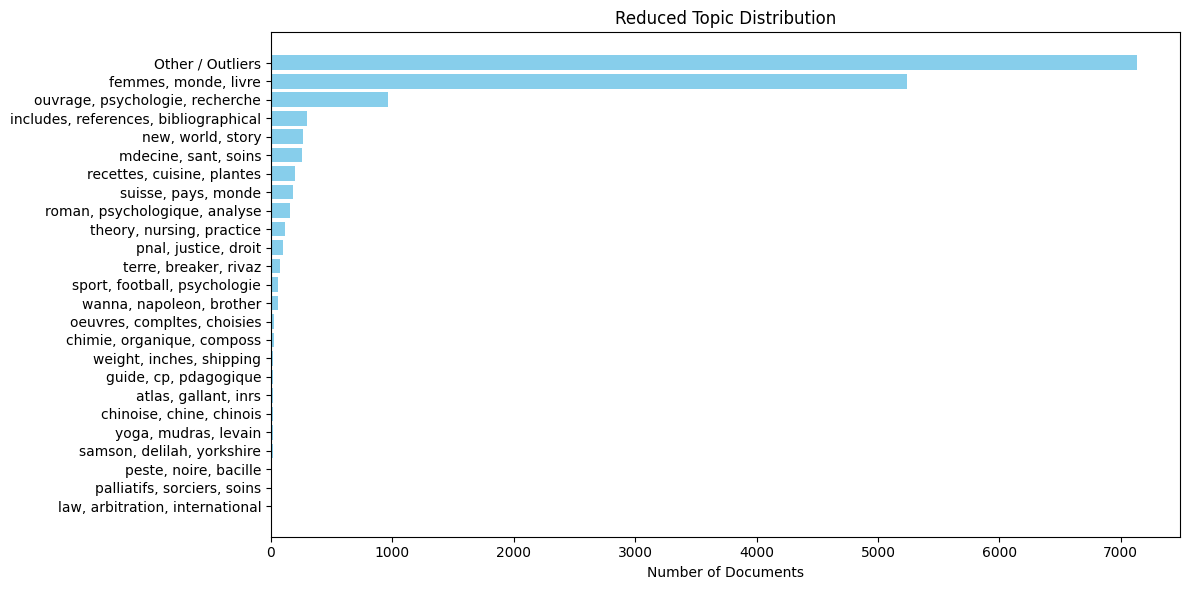

In [ ]:
import matplotlib.pyplot as plt
import copy
import seaborn as sns
original_topics = copy.deepcopy(topics)
# Step 1: Reduce the number of topics
topic_model.reduce_topics(cleaned_documents, nr_topics=25)

# Step 2: Recompute topic counts
reduced_topics = topic_model.transform(cleaned_documents)[0]
topic_counts = pd.Series(reduced_topics).value_counts().sort_values(ascending=False)

# Step 3: Use top keywords for each topic as labels
topic_labels = []
for topic in topic_counts.index:
    if topic == -1:
        label = "Other / Outliers"
    else:
        words = topic_model.get_topic(topic)
        label = ", ".join([word for word, _ in words[:3]]) if words else f"Topic {topic}"
    topic_labels.append(label)

# Step 4: Build DataFrame
topic_df = pd.DataFrame({
    "Topic": topic_counts.index,
    "Count": topic_counts.values,
    "Label": topic_labels
})



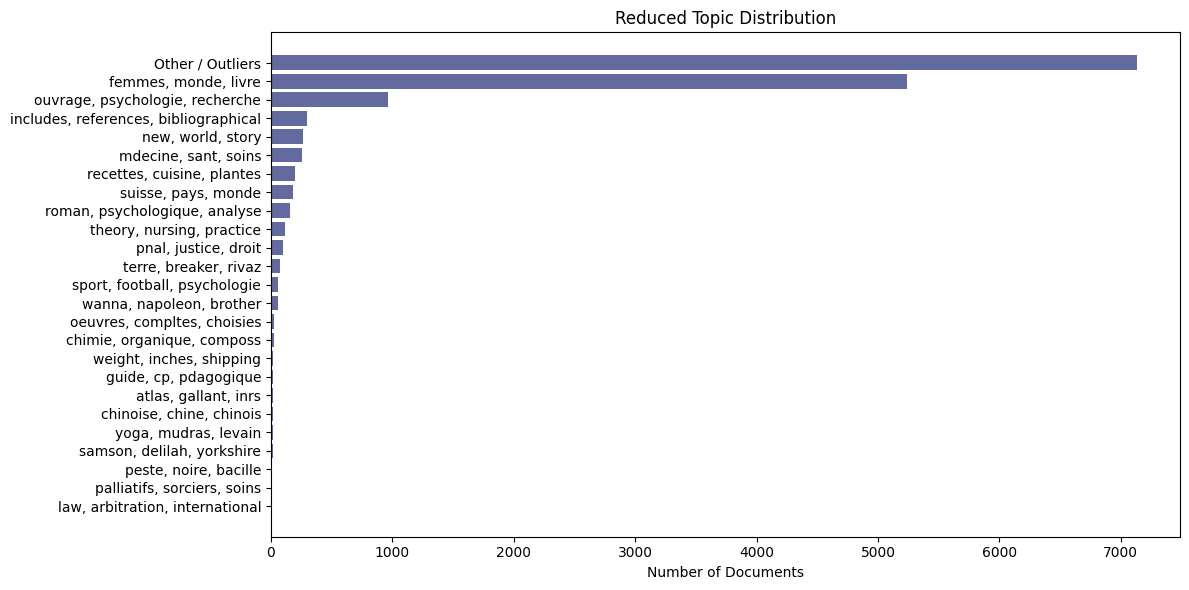

In [43]:
# Step 5: Plot with keyword labels
import seaborn as sns
palette = sns.color_palette("ch:s=.25,rot=-.25")
plt.figure(figsize=(12, 6))
bars = plt.barh(topic_df["Label"], topic_df["Count"], color=palette[3])
plt.gca().invert_yaxis()
plt.title("Reduced Topic Distribution")
plt.xlabel("Number of Documents")
plt.tight_layout()
plt.savefig("readme_images/reduced_topic_distribution.png")
plt.show()

In [27]:
fig = topic_model.visualize_topics()
fig.write_image("topic_map.png")
fig.show()

In [25]:
topic_model.reduce_topics(cleaned_documents, nr_topics=25)


In [26]:
fig = topic_model.visualize_topics()
fig.write_html("topic_map_25.html")

In [52]:
df_all_items['topic'] = topics
# Create a mapping: topic_id -> comma-separated keywords
topic_labels_dict = {
    topic_id: ", ".join([word for word, _ in words])
    for topic_id, words in topic_model.get_topics().items()
}
df_all_items['topic_label'] = df_all_items['topic'].map(topic_labels_dict)
df_all_items

,Unnamed: 0,CanonicalLink,Description,ISBN,ImageLink,Language,PublishedDate,Publisher,Subjects,Title,...,image,title_description,date_title_description,author_title_description,author_date_title_description,author_date_title,author_date_title_subjects,author_title_subjects,topic,topic_label
0,723,https://books.google.com/books/about/Classific...,,9782871303336,,fr,2012,Ed du CEFAL,Classification décimale universelle; Indexatio...,Classification décimale universelle : édition ...,...,https://images.isbndb.com/covers/8447463483210...,Classification décimale universelle : édition ...,2012 Classification décimale universelle : édi...,UDC Consortium (The Hague) Classification déci...,UDC Consortium (The Hague) 2012 Classification...,UDC Consortium (The Hague) 2012 Classification...,UDC Consortium (The Hague) 2012 Classification...,UDC Consortium (The Hague) Classification déc...,34,NaN
1,724,https://books.google.com/books/about/Les_inter...,C'est dans l'interaction en classe que s'actua...,9782278058327,,fr,2011,Didier,didactique--langue étrangère - enseignement; d...,Les interactions dans l'enseignement des langu...,...,https://images.isbndb.com/covers/2099063482999...,Les interactions dans l'enseignement des langu...,2011 Les interactions dans l'enseignement des ...,"Cicurel, Francine, Les interactions dans l'ens...","Cicurel, Francine, 2011 Les interactions dans ...","Cicurel, Francine, 2011 Les interactions dans ...","Cicurel, Francine, 2011 Les interactions dans ...","Cicurel, Francine, Les interactions dans l'en...",6,"suisse, pays, monde, vie, fes, vaud, histoire,..."
2,725,https://books.google.com/books/about/Histoire_...,Depuis la parution en 1918 de l'ouvrage fondat...,2343190194,http://books.google.com/books/content?id=Q2PMD...,fr,2020,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,Histoire de vie et recherche biographique : pe...,...,https://images.isbndb.com/covers/7444603483022...,Histoire de vie et recherche biographique : pe...,2020 Histoire de vie et recherche biographique...,"Aneta Slowik, Hervé Breton, Gaston Pineau Hist...","Aneta Slowik, Hervé Breton, Gaston Pineau 2020...","Aneta Slowik, Hervé Breton, Gaston Pineau 2020...","Aneta Slowik, Hervé Breton, Gaston Pineau 2020...","Aneta Slowik, Hervé Breton, Gaston Pineau His...",-1,"vie, monde, livre, roman, temps, ans, bien, nt..."
3,726,https://books.google.com/books/about/Ce_livre_...,,9782365350020,,fr,2012,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,Ce livre devrait me permettre de résoudre le c...,...,https://images.isbndb.com/covers/4356503483030...,Ce livre devrait me permettre de résoudre le c...,2012 Ce livre devrait me permettre de résoudre...,"Mazas, Sylvain, Ce livre devrait me permettre ...","Mazas, Sylvain, 2012 Ce livre devrait me perme...","Mazas, Sylvain, 2012 Ce livre devrait me perme...","Mazas, Sylvain, 2012 Ce livre devrait me perme...","Mazas, Sylvain, Ce livre devrait me permettre...",0,"femmes, monde, livre, vie, histoire, guerre, p..."
4,727,https://books.google.com/books/about/Le_grand_...,"Trois histoires d'amour, un lanceur d'alerte, ...",9782702180815,http://books.google.com/books/content?id=f5u3z...,fr,2024,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,Les années glorieuses : roman /,...,https://images.isbndb.com/covers/2369653483150...,Les années glorieuses : roman Trois histoires ...,2024 Les années glorieuses : roman Trois histo...,"Lemaitre, Pierre, Les années glorieuses : roma...","Lemaitre, Pierre, 2024 Les années glorieuses :...","Lemaitre, Pierre, 2024 Les années glorieuses :...","Lemaitre, Pierre, 2024 Les années glorieuses :...","Lemaitre, Pierre, Les années glorieuses : rom...",19,"yoga, mudras, levain, mudra, gasquet, postures..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15286,15287,https://books.google.com/books/about/Le_vagabo...,,9782353480111,,fr,,Le Lézard noir,Mangas,Le vagabond de Tokyo /,...,https://images.isbndb.com/cove

In [62]:
df_all_items.fillna("", inplace=True)
df_all_items['author_date_title_topics']  = df_all_items['author_clean'] + ' ' + df_all_items['PublishedDate'] + ' ' + df_all_items['title_clean'] + ' ' + df_all_items['topic_label']

In [63]:
save_embeddings(df_all_items, ['author_date_title_topics'], extra_description = '_topic')

Embedding columns: 100%|██████████| 1/1 [03:46<00:00, 226.51s/it]
